In [1]:
#Import all the necessary packages
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F
from torch.distributions import Categorical
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from scipy import signal
from torch.utils.tensorboard import SummaryWriter

In [2]:
# default `log_dir` is "runs" 
writer = SummaryWriter('runs/Trading_bot_2/')

In [3]:
#Load data into pandas dataframe
goog = pd.read_csv('GOOG.csv')

In [4]:
goog

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-08-12,242.212219,247.622620,241.496490,246.251251,246.251251,4404700
1,2010-08-13,244.744751,245.840836,243.248245,243.418411,243.418411,3865500
2,2010-08-16,242.082077,245.180176,240.490494,243.038040,243.038040,2607300
3,2010-08-17,244.509506,247.597595,243.258255,245.505508,245.505508,3777600
4,2010-08-18,245.465469,245.680679,241.016022,241.316315,241.316315,5367400
...,...,...,...,...,...,...,...
1756,2017-08-03,949.099976,950.000000,939.440002,940.299988,940.299988,1123900
1757,2017-08-04,943.950012,947.539978,939.799988,945.789978,945.789978,1254600
1758,2017-08-07,947.520020,948.960022,943.500000,945.750000,945.750000,1445800
1759,2017-08-08,944.289978,952.489990,942.479980,944.190002,944.190002,1505100


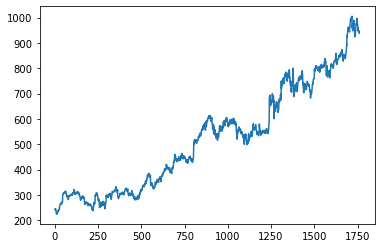

In [5]:
plt.plot(range(0, len(goog.Open)), goog.Open)

In [6]:
#Load aapl data into pandas dataframe
aapl = pd.read_csv('AAPL.csv')

In [7]:
aapl

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-08-12,35.241428,36.157143,35.160000,35.970001,24.171816,133730100
1,2010-08-13,35.950001,35.982857,35.584286,35.585712,23.913574,88717300
2,2010-08-16,35.368572,35.715714,35.231430,35.377144,23.773415,79607500
3,2010-08-17,35.725716,36.375713,35.599998,35.995716,24.189100,105660100
4,2010-08-18,36.051430,36.381428,35.939999,36.152859,24.294704,84924000
...,...,...,...,...,...,...,...
1756,2017-08-03,157.050003,157.210007,155.020004,155.570007,152.653320,27097300
1757,2017-08-04,156.070007,157.399994,155.690002,156.389999,153.457947,20559900
1758,2017-08-07,157.059998,158.919998,156.669998,158.809998,155.832596,21870300
1759,2017-08-08,158.600006,161.830002,158.270004,160.080002,157.078781,36205900


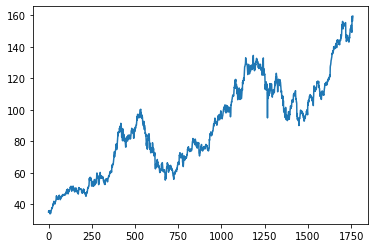

In [8]:
plt.plot(range(0, len(aapl.Open)), aapl.Open)

In [9]:
#Define trading environment 
class TradingEnvironment():
   
    def __init__(self, data_open = goog.Open, data_close = goog.Close, data2_open = aapl.Open, data2_close = aapl.Close, series_length=200, starting_point=0):
        
        self.data_open = data_open
        self.data_close = data_close
        self.data2_open = data2_open
        self.data2_close = data2_close
        #Observation space [No.of shares, Cash in hand, next opening price, portfolio value, past 5 day average]
        self.state = torch.FloatTensor(torch.zeros(8))
        #Starting cash
        self.starting_cash = 6000
        #Length of time series
        self.series_length = series_length
        self.starting_point = starting_point
        self.cur_timestep = self.starting_point
        #Initial No.of shares stock1
        self.state[0] = 20
        #Initial No.of shares stock2
        self.state[1] = 20
        #Starting portfolio value
        self.starting_portfolio_value = self.portfolio_value()
        self.state[2] = self.starting_cash
        #current Opening price -goog
        self.state[3] = self.data_open[self.cur_timestep]
        #current Opening price -aapl
        self.state[4] = self.data2_open[self.cur_timestep]
        self.state[5] = self.starting_portfolio_value
        #5 day average price -goog
        self.state[6] = self.five_day_window()[0]
        #5 day average price -aapl
        self.state[7] = self.five_day_window()[1]
        #Inventory holds the price of bought goog stock
        self.inventory = []
        num = int(self.state[0].item())
        #Append current price for the initial stocks
        for i in range(num):
            self.inventory.append(self.data_open[self.cur_timestep])
        
         #Inventory holds the price of bought aapl stock
        self.inventory_aapl = []
        num = int(self.state[1].item())
        #Append current price for the initial stocks
        for i in range(num):
            self.inventory_aapl.append(self.data2_open[self.cur_timestep])

        self.done = False
        self.profit = 0
    
    def portfolio_value(self):#To calculate total portfolio value
        return ((self.state[0] * self.data_close[self.cur_timestep]) + (self.state[1] * self.data2_close[self.cur_timestep]) + self.state[2])
   
    def next_opening_price(self):#Finding the next opening price
        step = self.cur_timestep + 1
        return [self.data_open[step], self.data2_open[step]]
    
    def five_day_window(self):#past Five day average calc
        step = self.cur_timestep
        if step < 5:
            return [self.data_open[0],self.data2_open[0]]
        goog5 = self.data_open[step-5:step].mean()
        apl5 = self.data2_open[step-5:step].mean()
        return [goog5, apl5]

    
    def step(self, action):
        delta1 = 0
        delta2 = 0
        action = [action, 1.]
        cur_timestep = self.cur_timestep
        retval = None
        cur_value = self.portfolio_value()
        
        #Check if done
        if cur_timestep >= self.starting_point + (self.series_length * 1):
            new_state = [self.state[0], self.state[1],  self.state[2], *self.next_opening_price(), cur_value, *self.five_day_window()]
            self.state = new_state
            if self.profit > 0:
                rew = 1
            else:
                rew = 0
            return new_state, rew, True, { "msg": "done"}
        #action ==2 ,Do nothing return the next state
        if action[0] == 2:
            new_state = [self.state[0], self.state[1],  self.state[2], *self.next_opening_price(), cur_value, *self.five_day_window()]
            self.state = new_state
            retval = new_state, 0, False, { "msg": "nothing" }
             
        #Action = 0, Buy goog, if there is enough cash in hand, and reward is 1 if bought for lower price than previous buy, else reward is 0    
        if action[0] == 0:
            if action[1] * self.data_open[cur_timestep] < self.state[2]:
                goog_shares = self.state[0] + action[1]
                cash_spent = action[1] * self.data_open[cur_timestep]
                new_state = [goog_shares, self.state[1], self.state[2]- cash_spent, *self.next_opening_price(), cur_value, *self.five_day_window()]
                self.state = new_state
                prev_price = self.inventory[-1]
                delt = prev_price - self.data_open[cur_timestep]
                self.state = new_state
                if delt > 0:
                    rew = 1
                else:
                    rew = 0
                self.inventory.append(self.data_open[self.cur_timestep])
                retval = new_state, rew, False, { "msg": "bought goog"}
            else:#If there is no enough cash in hand, end episode
                new_state = [self.state[0], self.state[1], self.state[2], *self.next_opening_price(), cur_value, *self.five_day_window()]
                self.state = new_state
                retval = new_state, 0, True, { "msg": "Bankrupt"}
                
        if action[0] == 1: #Action = 1, Sell goog, if there is enough stock, and reward is 1 if sold for higher price than bought, else reward is 0    
            if action[1] < self.state[0]:
                goog_shares = self.state[0] - action[1]
                cash_gained = action[1] * self.data_open[cur_timestep]
                new_state = [goog_shares, self.state[1], self.state[2] + cash_gained, *self.next_opening_price(), cur_value, *self.five_day_window()]
                bought_price = self.inventory.pop(0)
                delta1 = self.data_open[cur_timestep] - bought_price
                self.state = new_state
                if delta1 > 0:
                    rew = 1
                else:
                    rew = 0
                retval = new_state, rew, False, { "msg": "sold goog"}  
            else:#End episode if selling more than have
                new_state = [self.state[0], self.state[1], self.state[2], *self.next_opening_price(), cur_value, *self.five_day_window()]
                self.state = new_state
                retval = new_state, 0, True, { "msg": "Sold more than have"}
        
               
        #Action = 0, Buy aapl, if there is enough cash in hand, and reward is 1 if bought for lower price than previous buy, else reward is 0    
        if action[0] == 3:
            if action[1] * self.data2_open[cur_timestep] < self.state[2]:
                aapl_shares = self.state[1] + action[1]
                cash_spent = action[1] * self.data2_open[cur_timestep]
                new_state = [self.state[0], aapl_shares, self.state[2]- cash_spent, *self.next_opening_price(), cur_value, *self.five_day_window()]
                self.state = new_state
                prev_price = self.inventory_aapl[-1]
                delt = prev_price - self.data2_open[cur_timestep]
                self.state = new_state
                if delt > 0:
                    rew = 1
                else:
                    rew = 0
                self.inventory_aapl.append(self.data2_open[self.cur_timestep])
                retval = new_state, rew, False, { "msg": "bought aapl"}
            else:#If there is no enough cash in hand, end episode
                new_state = [self.state[0], self.state[1], self.state[2], *self.next_opening_price(), cur_value, *self.five_day_window()]
                self.state = new_state
                retval = new_state, 0, True, { "msg": "Bankrupt"}
                
        if action[0] == 4: #Action = 1, Sell goog, if there is enough stock, and reward is 1 if sold for higher price than bought, else reward is 0    
            if action[1] < self.state[1]:
                aapl_shares = self.state[1] - action[1]
                cash_gained = action[1] * self.data2_open[cur_timestep]
                new_state = [self.state[0], aapl_shares, self.state[2] + cash_gained, *self.next_opening_price(), cur_value, *self.five_day_window()]
                bought_price = self.inventory_aapl.pop(0)
                delta2 = self.data2_open[cur_timestep] - bought_price
                self.state = new_state
                if delta2 > 0:
                    rew = 1
                else:
                    rew = 0
                retval = new_state, rew, False, { "msg": "sold aapl"}  
            else:#End episode if selling more than have
                new_state = [self.state[0], self.state[1], self.state[2], *self.next_opening_price(), cur_value, *self.five_day_window()]
                self.state = new_state
                retval = new_state, 0, True, { "msg": "Sold more than have"}
        
                
        #Calculate selling profit      
        self.profit += (delta1 + delta2)
        #Increase step
        self.cur_timestep += 1
        return retval
    
    def reset(self):#Reset observation space and timestep
        self.state = torch.FloatTensor(torch.zeros(8))
        self.starting_cash = 6000
        self.cur_timestep = self.starting_point
        #Initial No.of shares stock1
        self.state[0] = 20
        #Initial No.of shares stock2
        self.state[1] = 20
        self.state[2] = self.starting_cash
        #current Opening price -goog
        self.state[3] = self.data_open[self.cur_timestep]
        #current Opening price -aapl
        self.state[4] = self.data2_open[self.cur_timestep]
        #Starting portfolio value
        self.starting_portfolio_value = self.portfolio_value()
        self.state[5] = self.starting_portfolio_value
        #5 day average price -goog
        self.state[6] = self.five_day_window()[0]
        #5 day average price -aapl
        self.state[7] = self.five_day_window()[1]
        #Inventory holds the price of bought goog stock
        self.inventory = []
        num = int(self.state[0].item())
        #Append current price for the initial stocks
        for i in range(num):
            self.inventory.append(self.data_open[self.cur_timestep])
         #Inventory holds the price of bought aapl stock
        self.inventory_aapl = []
        num1 = int(self.state[1].item())
        #Append current price for the initial stocks
        for i in range(num1):
            self.inventory_aapl.append(self.data2_open[self.cur_timestep])
        self.done = False   
        self.profit = 0
        return self.state

In [10]:
#Define actor critic neural network
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.input_layer = nn.Linear(8, 128)
        self.hidden_1 = nn.Linear(128, 32)
        self.hidden_2 = nn.Linear(32,31)
        #Actor Layer
        self.action_head = nn.Linear(31, 5)
        #Critic Layer
        self.value_head = nn.Linear(31, 1)
        self.saved_actions = []
        self.rewards = []
        
    def forward(self, x):
        x = torch.tensor(x)
        x = torch.sigmoid(self.input_layer(x))
        x = F.relu(self.hidden_1(x))
        x = F.relu(self.hidden_2(x))
        action_scores = self.action_head(x)
        state_values = self.value_head(x)
        return F.softmax(action_scores, dim=-1), state_values
    
    def act(self, state):
        probs, state_value = self.forward(state)
        m = Categorical(probs)
        #Get an action
        action = m.sample()
        #If action is sell and no.of share is zero, force it to do nothing
        if action == 1 and env.state[0] < 1: action = torch.LongTensor([2]).squeeze()
        if action == 4 and env.state[1] < 1: action = torch.LongTensor([2]).squeeze()
        self.saved_actions.append((m.log_prob(action), state_value))
        return action.item()

In [11]:
#Define Environment, Agent, optimizer
env = TradingEnvironment(data_open = goog.Open, data_close = goog.Close,data2_open = aapl.Open, data2_close = aapl.Close, series_length= len(goog.Open)-2)
model = Policy()
optimizer = optim.Adam(model.parameters(), lr=3e-4)

In [12]:
env.reset()
gamma = 0.988
#Log every 50 episode
log_interval = 100

#At the end of each episode update gardients
def finish_episode(episode):
    R = 0
    saved_actions = model.saved_actions
    policy_losses = []
    value_losses = []
    returns = []
    #Calculate discounted reward
    for r in model.rewards[::-1]:
        R = r + (gamma * R)
        returns.insert(0, R)
        
    returns = torch.tensor(returns)
    
    #Standardize the discounted reward (Helps converge faster)
    eps = np.finfo(np.float32).eps.item()
    returns = (returns - returns.mean()) / (returns.std() + eps)
    #Calculate policy and value loss  
    for (log_prob, value), R in zip(saved_actions, returns):
        #Calculate advantage value
        advantage = torch.tensor(R - value.item())
        policy_losses.append(-log_prob * advantage)
        #Smooth L1 loss has the advantage of both L1 and L2 loss
        value_losses.append(F.smooth_l1_loss(value, torch.tensor([R])))

    #Reset gradients           
    optimizer.zero_grad()
    #Sum up policy and value losses
    loss = torch.stack(policy_losses).mean() + torch.stack(value_losses).mean()
    writer.add_scalar('Policy loss',torch.stack(policy_losses).mean(), episode)
    writer.add_scalar('Value loss',torch.stack(value_losses).mean(), episode)
    writer.add_scalar('Total loss',loss, episode)
    #Backpropogation
    loss.backward()
    optimizer.step()    
    #Delete saved rewards and actions
    del model.rewards[:]
    del model.saved_actions[:]

In [13]:
#Start training
running_reward = 100
#Train for 1000 episodes
for episode in range(0,2000):
    state = env.reset()
    done = False
    msg = None
    ep_rew = 0
    while not done:
        action = model.act(state)
        state, reward, done, msg = env.step(action)
        #print(action,state,reward)
        model.rewards.append(reward)
        ep_rew += reward
        if done:
            break
    finish_episode(episode)
    running_reward = running_reward * (1 - 0.05) + ep_rew * (0.05)
     # ...log the running reward
    writer.add_scalar('Running reward',running_reward,episode)
    #stop training if the threshold is reached
    if msg["msg"] == "done" and env.portfolio_value() > env.starting_portfolio_value * 1.1 and reward == 1 and running_reward > 1000:
        print("Early Stopping--- Profit :" + str(int(env.profit)))
        break
    #Log every 10 episodes
    if episode % log_interval == 0:
        print("""Episode {}: started at {:.1f}, finished at {:.1f} because {} @ t={}, last reward {} \
episode reward {:.1f}, running reward {:.1f}""".format(episode, env.starting_portfolio_value, \
              env.portfolio_value(), msg["msg"], env.cur_timestep, reward, ep_rew, running_reward))

C:\Users\Thasleem\anaconda3\envs\cmpe_255\lib\site-packages\ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
C:\Users\Thasleem\anaconda3\envs\cmpe_255\lib\site-packages\ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Episode 0: started at 11644.4, finished at 14780.8 because Sold more than have @ t=812, last reward 0 episode reward 362.0, running reward 113.1
Episode 100: started at 11644.4, finished at 13638.9 because Sold more than have @ t=468, last reward 0 episode reward 228.0, running reward 364.8
Episode 200: started at 11644.4, finished at 25940.8 because done @ t=1759, last reward 1 episode reward 831.0, running reward 465.2
Episode 300: started at 11644.4, finished at 15344.8 because Sold more than have @ t=795, last reward 0 episode reward 407.0, running reward 489.1
Episode 400: started at 11644.4, finished at 14786.8 because Bankrupt @ t=421, last reward 0 episode reward 221.0, running reward 490.6
Episode 500: started at 11644.4, finished at 18033.9 because Sold more than have @ t=1045, last reward 0 episode reward 564.0, running reward 632.3
Episode 600: started at 11644.4, finished at 30172.9 because done @ t=1759, last reward 1 episode reward 1038.0, running reward 738.0
Episode 70

In [14]:
#Check out a sample run
env.reset()
print("starting portfolio value {}".format(env.portfolio_value()))
for i in range(0,env.series_length + 1):
    action = model.act(env.state)
    next_state, reward, done, msg = env.step(action)
    if msg["msg"] == 'bankrupted self':
        print('bankrupted self by 1')
        break
    if msg["msg"] == 'sold more than have':
        print('sold more than have by 1')
        break
    print("{}, have {} goog, have {} appl, ${} cash ".format(msg["msg"], next_state[0], next_state[1], next_state[2]))
    if msg["msg"] == "done":
        print("total portfolio value {}".format(env.portfolio_value()))
        break

starting portfolio value 11644.4248046875
bought aapl, have 20.0 goog, have 21.0 appl, $5964.7587890625 cash 
sold aapl, have 20.0 goog, have 20.0 appl, $6000.708984375 cash 
bought aapl, have 20.0 goog, have 21.0 appl, $5965.34033203125 cash 
bought aapl, have 20.0 goog, have 22.0 appl, $5929.61474609375 cash 
bought aapl, have 20.0 goog, have 23.0 appl, $5893.5634765625 cash 
sold goog, have 19.0 goog, have 23.0 appl, $6134.30908203125 cash 
bought aapl, have 19.0 goog, have 24.0 appl, $6098.68212890625 cash 
bought goog, have 20.0 goog, have 24.0 appl, $5867.701171875 cash 
bought aapl, have 20.0 goog, have 25.0 appl, $5833.0341796875 cash 
bought goog, have 21.0 goog, have 25.0 appl, $5607.80908203125 cash 
sold aapl, have 21.0 goog, have 24.0 appl, $5642.87353515625 cash 
sold aapl, have 21.0 goog, have 23.0 appl, $5677.4091796875 cash 
bought aapl, have 21.0 goog, have 24.0 appl, $5643.0146484375 cash 
sold goog, have 20.0 goog, have 24.0 appl, $5868.294921875 cash 
bought aapl, 

C:\Users\Thasleem\anaconda3\envs\cmpe_255\lib\site-packages\ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app



bought aapl, have 19.0 goog, have 28.0 appl, $5977.6630859375 cash 
bought aapl, have 19.0 goog, have 29.0 appl, $5935.5576171875 cash 
bought aapl, have 19.0 goog, have 30.0 appl, $5893.35595703125 cash 
sold aapl, have 19.0 goog, have 29.0 appl, $5936.24169921875 cash 
sold aapl, have 19.0 goog, have 28.0 appl, $5979.34033203125 cash 
sold aapl, have 19.0 goog, have 27.0 appl, $6023.26025390625 cash 
sold aapl, have 19.0 goog, have 26.0 appl, $6068.755859375 cash 
bought goog, have 20.0 goog, have 26.0 appl, $5764.0263671875 cash 
sold aapl, have 20.0 goog, have 25.0 appl, $5808.16943359375 cash 
bought aapl, have 20.0 goog, have 26.0 appl, $5763.54638671875 cash 
bought aapl, have 20.0 goog, have 27.0 appl, $5719.3935546875 cash 
sold aapl, have 20.0 goog, have 26.0 appl, $5763.54931640625 cash 
sold aapl, have 20.0 goog, have 25.0 appl, $5807.3876953125 cash 
sold aapl, have 20.0 goog, have 24.0 appl, $5851.337890625 cash 
bought aapl, have 20.0 goog, have 25.0 appl, $5807.3452148

bought aapl, have 24.0 goog, have 35.0 appl, $4118.767578125 cash 
bought aapl, have 24.0 goog, have 36.0 appl, $4072.067626953125 cash 
sold aapl, have 24.0 goog, have 35.0 appl, $4119.06640625 cash 
sold aapl, have 24.0 goog, have 34.0 appl, $4164.4033203125 cash 
bought aapl, have 24.0 goog, have 35.0 appl, $4119.1630859375 cash 
sold aapl, have 24.0 goog, have 34.0 appl, $4165.61474609375 cash 
sold aapl, have 24.0 goog, have 33.0 appl, $4211.177734375 cash 
bought aapl, have 24.0 goog, have 34.0 appl, $4163.83935546875 cash 
bought aapl, have 24.0 goog, have 35.0 appl, $4117.041015625 cash 
bought aapl, have 24.0 goog, have 36.0 appl, $4069.376708984375 cash 
sold aapl, have 24.0 goog, have 35.0 appl, $4117.38232421875 cash 
sold aapl, have 24.0 goog, have 34.0 appl, $4165.19677734375 cash 
bought aapl, have 24.0 goog, have 35.0 appl, $4117.2041015625 cash 
bought aapl, have 24.0 goog, have 36.0 appl, $4068.2041015625 cash 
bought aapl, have 24.0 goog, have 37.0 appl, $4018.354003

bought aapl, have 21.0 goog, have 53.0 appl, $4239.13037109375 cash 
bought aapl, have 21.0 goog, have 54.0 appl, $4152.36181640625 cash 
bought aapl, have 21.0 goog, have 55.0 appl, $4070.296142578125 cash 
bought aapl, have 21.0 goog, have 56.0 appl, $3987.473388671875 cash 
bought goog, have 22.0 goog, have 56.0 appl, $3677.71875 cash 
sold aapl, have 22.0 goog, have 55.0 appl, $3762.135986328125 cash 
bought goog, have 23.0 goog, have 55.0 appl, $3447.69140625 cash 
sold aapl, have 23.0 goog, have 54.0 appl, $3535.678466796875 cash 
bought goog, have 24.0 goog, have 54.0 appl, $3222.6103515625 cash 
bought goog, have 25.0 goog, have 54.0 appl, $2902.2900390625 cash 
sold aapl, have 25.0 goog, have 53.0 appl, $2990.474365234375 cash 
sold aapl, have 25.0 goog, have 52.0 appl, $3079.44140625 cash 
sold goog, have 24.0 goog, have 52.0 appl, $3399.2861328125 cash 
sold aapl, have 24.0 goog, have 51.0 appl, $3487.55029296875 cash 
sold aapl, have 24.0 goog, have 50.0 appl, $3575.9375 ca

sold aapl, have 25.0 goog, have 46.0 appl, $3649.439453125 cash 
bought aapl, have 25.0 goog, have 47.0 appl, $3586.003662109375 cash 
bought aapl, have 25.0 goog, have 48.0 appl, $3523.43212890625 cash 
sold aapl, have 25.0 goog, have 47.0 appl, $3584.54638671875 cash 
sold goog, have 24.0 goog, have 47.0 appl, $3999.42626953125 cash 
bought goog, have 25.0 goog, have 47.0 appl, $3578.490234375 cash 
sold goog, have 24.0 goog, have 47.0 appl, $3995.937744140625 cash 
bought aapl, have 24.0 goog, have 48.0 appl, $3934.537841796875 cash 
bought aapl, have 24.0 goog, have 49.0 appl, $3873.14501953125 cash 
sold goog, have 23.0 goog, have 49.0 appl, $4288.916015625 cash 
sold aapl, have 23.0 goog, have 48.0 appl, $4350.123046875 cash 
bought aapl, have 23.0 goog, have 49.0 appl, $4288.2900390625 cash 
sold aapl, have 23.0 goog, have 48.0 appl, $4350.8515625 cash 
sold aapl, have 23.0 goog, have 47.0 appl, $4413.916015625 cash 
bought aapl, have 23.0 goog, have 48.0 appl, $4348.27294921875

sold aapl, have 25.0 goog, have 46.0 appl, $3699.85205078125 cash 
sold aapl, have 25.0 goog, have 45.0 appl, $3774.283447265625 cash 
sold aapl, have 25.0 goog, have 44.0 appl, $3849.15771484375 cash 
bought goog, have 26.0 goog, have 44.0 appl, $3317.611083984375 cash 
sold goog, have 25.0 goog, have 44.0 appl, $3849.22265625 cash 
sold aapl, have 25.0 goog, have 43.0 appl, $3928.93701171875 cash 
sold aapl, have 25.0 goog, have 42.0 appl, $4008.694091796875 cash 
sold aapl, have 25.0 goog, have 41.0 appl, $4089.479736328125 cash 
bought aapl, have 25.0 goog, have 42.0 appl, $4007.672607421875 cash 
bought goog, have 26.0 goog, have 42.0 appl, $3472.2421875 cash 
sold aapl, have 26.0 goog, have 41.0 appl, $3552.370849609375 cash 
bought aapl, have 26.0 goog, have 42.0 appl, $3471.859375 cash 
sold aapl, have 26.0 goog, have 41.0 appl, $3552.859375 cash 
sold aapl, have 26.0 goog, have 40.0 appl, $3633.1650390625 cash 
bought aapl, have 26.0 goog, have 41.0 appl, $3552.7578125 cash 
s

bought aapl, have 25.0 goog, have 36.0 appl, $4531.19384765625 cash 
bought aapl, have 25.0 goog, have 37.0 appl, $4440.82373046875 cash 
sold aapl, have 25.0 goog, have 36.0 appl, $4531.6435546875 cash 
sold aapl, have 25.0 goog, have 35.0 appl, $4623.74365234375 cash 
bought goog, have 26.0 goog, have 35.0 appl, $4036.09375 cash 
bought aapl, have 26.0 goog, have 36.0 appl, $3942.2236328125 cash 
sold aapl, have 26.0 goog, have 35.0 appl, $4035.8935546875 cash 
sold aapl, have 26.0 goog, have 34.0 appl, $4130.03369140625 cash 
sold aapl, have 26.0 goog, have 33.0 appl, $4226.3037109375 cash 
sold aapl, have 26.0 goog, have 32.0 appl, $4321.74365234375 cash 
sold goog, have 25.0 goog, have 32.0 appl, $4894.74365234375 cash 
sold aapl, have 25.0 goog, have 31.0 appl, $4990.103515625 cash 
bought aapl, have 25.0 goog, have 32.0 appl, $4894.24365234375 cash 
bought aapl, have 25.0 goog, have 33.0 appl, $4797.44384765625 cash 
sold aapl, have 25.0 goog, have 32.0 appl, $4894.4140625 cash 

sold goog, have 18.0 goog, have 48.0 appl, $7013.96630859375 cash 
bought goog, have 19.0 goog, have 48.0 appl, $6474.96630859375 cash 
bought aapl, have 19.0 goog, have 49.0 appl, $6342.0263671875 cash 
sold aapl, have 19.0 goog, have 48.0 appl, $6473.58642578125 cash 
sold aapl, have 19.0 goog, have 47.0 appl, $6602.37646484375 cash 
bought goog, have 20.0 goog, have 47.0 appl, $6044.2265625 cash 
bought aapl, have 20.0 goog, have 48.0 appl, $5914.9765625 cash 
bought aapl, have 20.0 goog, have 49.0 appl, $5786.0166015625 cash 
bought aapl, have 20.0 goog, have 50.0 appl, $5656.91650390625 cash 
bought goog, have 21.0 goog, have 50.0 appl, $5077.29638671875 cash 
sold aapl, have 21.0 goog, have 49.0 appl, $5205.6962890625 cash 
bought aapl, have 21.0 goog, have 50.0 appl, $5077.736328125 cash 
bought aapl, have 21.0 goog, have 51.0 appl, $4951.326171875 cash 
bought aapl, have 21.0 goog, have 52.0 appl, $4826.576171875 cash 
bought goog, have 22.0 goog, have 52.0 appl, $4268.09619140

bought aapl, have 20.0 goog, have 47.0 appl, $6086.58544921875 cash 
bought aapl, have 20.0 goog, have 48.0 appl, $5976.70556640625 cash 
bought aapl, have 20.0 goog, have 49.0 appl, $5866.07568359375 cash 
nothing, have 20.0 goog, have 49.0 appl, $5866.07568359375 cash 
bought goog, have 21.0 goog, have 49.0 appl, $5196.62548828125 cash 
sold aapl, have 21.0 goog, have 48.0 appl, $5306.62548828125 cash 
sold goog, have 20.0 goog, have 48.0 appl, $5975.8154296875 cash 
sold goog, have 19.0 goog, have 48.0 appl, $6650.0751953125 cash 
sold aapl, have 19.0 goog, have 47.0 appl, $6761.365234375 cash 
sold aapl, have 19.0 goog, have 46.0 appl, $6872.29541015625 cash 
bought aapl, have 19.0 goog, have 47.0 appl, $6760.515625 cash 
bought goog, have 20.0 goog, have 47.0 appl, $6066.515625 cash 
sold aapl, have 20.0 goog, have 46.0 appl, $6177.85546875 cash 
bought aapl, have 20.0 goog, have 47.0 appl, $6063.85546875 cash 
bought aapl, have 20.0 goog, have 48.0 appl, $5949.525390625 cash 
bou

sold aapl, have 11.0 goog, have 38.0 appl, $13746.9853515625 cash 
bought aapl, have 11.0 goog, have 39.0 appl, $13648.294921875 cash 
sold aapl, have 11.0 goog, have 38.0 appl, $13745.615234375 cash 
sold goog, have 10.0 goog, have 38.0 appl, $14480.53515625 cash 
bought goog, have 11.0 goog, have 38.0 appl, $13752.5751953125 cash 
sold goog, have 10.0 goog, have 38.0 appl, $14473.96484375 cash 
bought aapl, have 10.0 goog, have 39.0 appl, $14377.96484375 cash 
bought aapl, have 10.0 goog, have 40.0 appl, $14283.0244140625 cash 
sold aapl, have 10.0 goog, have 39.0 appl, $14379.2744140625 cash 
bought aapl, have 10.0 goog, have 40.0 appl, $14283.333984375 cash 
sold aapl, have 10.0 goog, have 39.0 appl, $14376.244140625 cash 
bought aapl, have 10.0 goog, have 40.0 appl, $14283.244140625 cash 
bought aapl, have 10.0 goog, have 41.0 appl, $14190.34375 cash 
sold aapl, have 10.0 goog, have 40.0 appl, $14284.3134765625 cash 
bought aapl, have 10.0 goog, have 41.0 appl, $14189.873046875 ca

sold goog, have 13.0 goog, have 58.0 appl, $9896.19140625 cash 
sold aapl, have 13.0 goog, have 57.0 appl, $10029.271484375 cash 
bought aapl, have 13.0 goog, have 58.0 appl, $9895.8017578125 cash 
bought aapl, have 13.0 goog, have 59.0 appl, $9760.2822265625 cash 
bought aapl, have 13.0 goog, have 60.0 appl, $9624.6123046875 cash 
sold aapl, have 13.0 goog, have 59.0 appl, $9759.7119140625 cash 
bought aapl, have 13.0 goog, have 60.0 appl, $9623.4814453125 cash 
bought aapl, have 13.0 goog, have 61.0 appl, $9487.0517578125 cash 
bought aapl, have 13.0 goog, have 62.0 appl, $9349.671875 cash 
sold aapl, have 13.0 goog, have 61.0 appl, $9485.58203125 cash 
bought aapl, have 13.0 goog, have 62.0 appl, $9348.4423828125 cash 
sold aapl, have 13.0 goog, have 61.0 appl, $9485.5224609375 cash 
bought aapl, have 13.0 goog, have 62.0 appl, $9347.6328125 cash 
bought aapl, have 13.0 goog, have 63.0 appl, $9207.6328125 cash 
sold aapl, have 13.0 goog, have 62.0 appl, $9346.4130859375 cash 
bought

In [15]:
torch.save(model.state_dict(),'./AC_model_2')

In [11]:
#Load saved model
model = Policy()
model.load_state_dict(torch.load('./AC_model_2'))

<All keys matched successfully>

#### Testing on Google_2019 and aapl_2019 dataset

In [12]:
#Load test dataset
te_aapl = pd.read_csv('AAPL_2019.csv')

In [13]:
te_aapl

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-02,154.889999,158.850006,154.229996,157.919998,155.214005,37039700
1,2019-01-03,143.979996,145.720001,142.000000,142.190002,139.753540,91312200
2,2019-01-04,144.529999,148.550003,143.800003,148.259995,145.719513,58607100
3,2019-01-07,148.699997,148.830002,145.899994,147.929993,145.395203,54777800
4,2019-01-08,149.559998,151.820007,148.520004,150.750000,148.166870,41025300
...,...,...,...,...,...,...,...
247,2019-12-24,284.690002,284.890015,282.920013,284.269989,283.596924,12119700
248,2019-12-26,284.820007,289.980011,284.700012,289.910004,289.223602,23280300
249,2019-12-27,291.119995,293.970001,288.119995,289.799988,289.113831,36566500
250,2019-12-30,289.459991,292.690002,285.220001,291.519989,290.829773,36028600


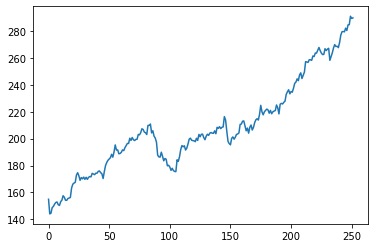

In [14]:
plt.plot(range(0,len(te_aapl.Open)),te_aapl.Open)

In [15]:
#Load test dataset
te_goog = pd.read_csv('GOOG_2019.csv')

In [16]:
te_goog

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-02,1016.570007,1052.319946,1015.710022,1045.849976,1045.849976,1532600
1,2019-01-03,1041.000000,1056.979980,1014.070007,1016.059998,1016.059998,1841100
2,2019-01-04,1032.589966,1070.839966,1027.417969,1070.709961,1070.709961,2093900
3,2019-01-07,1071.500000,1074.000000,1054.760010,1068.390015,1068.390015,1981900
4,2019-01-08,1076.109985,1084.560059,1060.530029,1076.280029,1076.280029,1764900
...,...,...,...,...,...,...,...
246,2019-12-23,1355.869995,1359.800049,1346.510010,1348.839966,1348.839966,883100
247,2019-12-24,1348.500000,1350.260010,1342.780029,1343.560059,1343.560059,347500
248,2019-12-26,1346.170044,1361.327026,1344.469971,1360.400024,1360.400024,667500
249,2019-12-27,1362.989990,1364.530029,1349.310059,1351.890015,1351.890015,1038400


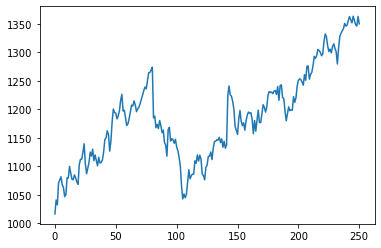

In [17]:
plt.plot(range(0,len( te_goog.Open)),  te_goog.Open)

In [39]:
#Past test data to trading environment
env = TradingEnvironment(data_open=te_goog.Open, data_close = te_goog.Close, data2_open=te_aapl.Open, data2_close = te_aapl.Close, series_length=len(te_goog.Close)-2)
env.reset()

print('Starting Portfolio value :',env.portfolio_value().item())
state = env.reset()
reward = 0
done = False
msg = None
#Create empty lists to store the action times
bg_action_times = []
sg_action_times = []
ba_action_times = []
sa_action_times = []
n_action_times = []

while not done:
    action = model.act(state)
    if action == 0:
        bg_action_times.append(env.cur_timestep)
    if action == 1:
        sg_action_times.append(env.cur_timestep)
    if action == 2:
        n_action_times.append(env.cur_timestep)
    if action == 3:
        ba_action_times.append(env.cur_timestep)
    if action == 4:
        sa_action_times.append(env.cur_timestep)
    
    state, reward, done, msg = env.step(action)
    model.rewards.append(reward)
if msg["msg"] == "done":
        print("Have {} goog, Have {} aapl and ${} cash. selling profit: {}, Total portfolio value: {}".format(state[0], state[1], state[2], env.profit, env.portfolio_value()))
    

Starting Portfolio value : 30075.400390625


C:\Users\Thasleem\anaconda3\envs\cmpe_255\lib\site-packages\ipykernel_launcher.py:16: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Have 15.0 goog, Have 8.0 aapl and $14608.76171875 cash. selling profit: 5051.390013, Total portfolio value: 37205.51171875


In [40]:
#Get date and open price of buy sell actions from timestamps for plotting
buy_date_g = [te_goog.Date[x] for x in bg_action_times]
sell_date_g = [te_goog.Date[x] for x in sg_action_times]
buy_date_a = [te_aapl.Date[x] for x in ba_action_times]
sell_date_a = [te_aapl.Date[x] for x in sa_action_times]
bought_goog_at = [te_goog.Open[x] for x in bg_action_times]
sold_goog_at = [te_goog.Open[x] for x in sg_action_times]
bought_aapl_at = [te_aapl.Open[x] for x in ba_action_times]
sold_aapl_at = [te_aapl.Open[x] for x in sa_action_times]

In [41]:
# Using plotly.express
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
fig = make_subplots(rows=1, cols=2)
fig.add_trace(go.Scatter(x = te_goog.Date,y = te_goog.Open, mode="lines",showlegend=True,name="Goog_stock"),  row=1, col=1)
fig.add_trace(go.Scatter(x = buy_date_g,y = bought_goog_at, mode="markers",showlegend=True,name="Buy"),  row=1, col=1)
fig.add_trace(go.Scatter(x = sell_date_g,y = sold_goog_at, mode="markers",showlegend=True,name="Sell"),  row=1, col=1)
fig.add_trace(go.Scatter(x = te_aapl.Date,y = te_aapl.Open, mode="lines",showlegend=True,name="AAPL_stock"),  row=1, col=2)
fig.add_trace(go.Scatter(x = buy_date_a,y = bought_aapl_at, mode="markers",showlegend=True,name="Buy"),row=1, col=2)
fig.add_trace(go.Scatter(x = sell_date_a,y = sold_aapl_at, mode="markers",showlegend=True,name="Sell"),row=1, col=2)
fig.update_layout(title="AC Test results on Goog and AAPL 2019",annotations=[dict(text='Selling profit :' +str(env.profit.round()) +  ',End portfolio value :' +str(env.portfolio_value().round().item()),
                showarrow=False, xref='paper',yref='paper', x=0.1, y=1.1, font=dict(size=16))] )      
fig.show()